## Step 1 – Upload and Load the Dataset (CSV)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

#The Google Play Store Apps dataset was used,consisting of the file googleplaystore.csv, which contains application metadata such as category, rating, installs, reviews, size, and price.
df_raw = pd.read_csv("googleplaystore.csv")
df_raw.head()


Saving googleplaystore.csv to googleplaystore.csv


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


##Step 2 – Inspect the Dataset

In [5]:
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

df_raw.info()
df_raw.describe(include="all")
df_raw.isnull().sum().sort_values(ascending=False)

df_raw.describe()  # numeric summary (min, max, mean)


Shape: (10841, 13)
Columns: ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memor

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [ ]:
missing_pct = (df_raw.isnull().mean() * 100).sort_values(ascending=False)
print("Missing % (top):")
print(missing_pct.head(20))

dup_count = df_raw.duplicated().sum()
print("Duplicate rows:", dup_count)


Missing % (top):
Rating            13.596532
Current Ver        0.073794
Android Ver        0.027673
Content Rating     0.009224
Type               0.009224
Size               0.000000
Reviews            0.000000
Category           0.000000
App                0.000000
Price              0.000000
Installs           0.000000
Last Updated       0.000000
Genres             0.000000
dtype: float64
Duplicate rows: 483


In [ ]:
df = df_raw.copy()


In [ ]:
#Handling Missing Values
THRESHOLD = 40  # percent missing considered "too many"
cols_to_drop = missing_pct[missing_pct >= THRESHOLD].index.tolist()
print("Dropping columns (>= 40% missing):", cols_to_drop)

df = df.drop(columns=cols_to_drop)


Dropping columns (>= 40% missing): []


In [ ]:
# Strip spaces in text columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Reviews -> numeric
if "Reviews" in df.columns:
    df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")

# Installs -> numeric (remove commas and +)
if "Installs" in df.columns:
    df["Installs"] = df["Installs"].astype(str).str.replace(r"[+,]", "", regex=True)
    df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")

# Price -> numeric (remove $)
if "Price" in df.columns:
    df["Price"] = df["Price"].astype(str).str.replace("$", "", regex=False)
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Rating -> numeric
if "Rating" in df.columns:
    df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

# Size -> normalize to MB in new column Size_MB
# Common values: "19M", "14k", "Varies with device"
# Create Size_MB safely (numeric size in MB)
if "Size" in df.columns: # Add this check to prevent KeyError on re-execution
    s = df["Size"].astype(str).str.strip()

    size_mb = np.where(
        s.str.endswith("M"),
        pd.to_numeric(s.str.replace("M", "", regex=False), errors="coerce"),
        np.where(
            s.str.endswith("k"),
            pd.to_numeric(s.str.replace("k", "", regex=False), errors="coerce") / 1024,
            np.nan
        )
    )

    df["Size_MB"] = size_mb

    # Drop original Size column to avoid confusion in analysis
    df = df.drop(columns=["Size"])

In [ ]:
# Fill numeric with MEDIAN (robust to outliers)
# Numeric columns were filled with the median to reduce the effect of outliers.
for col in ["Rating", "Reviews", "Installs", "Price", "Size_MB"]:
    if col in df.columns:
        med = df[col].median()
        df[col] = df[col].fillna(med)

# Fill categorical with MODE (most frequent)
# Categorical columns were filled with the mode to preserve the most common category.
for col in ["Type", "Content Rating", "Category", "Genres"]:
    if col in df.columns:
        df[col] = df[col].replace("nan", np.nan)  # because we converted to str earlier
        mode_val = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(mode_val)


In [ ]:
df.isnull().sum().sort_values(ascending=False).head(30)


,0
App,0
Category,0
Rating,0
Reviews,0
Size,0
Installs,0
Type,0
Price,0
Content Rating,0
Genres,0


In [ ]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print("Rows before:", before, "Rows after:", after, "Removed:", before-after)


Rows before: 10841 Rows after: 10358 Removed: 483


In [ ]:
# Dropping columns with low analytical value
# These columns do not affect installs, ratings, or category analysis
drop_cols = [c for c in ["Current Ver", "Android Ver"] if c in df.columns]
df = df.drop(columns=drop_cols)

print("Final shape:", df.shape)


Final shape: (10358, 11)


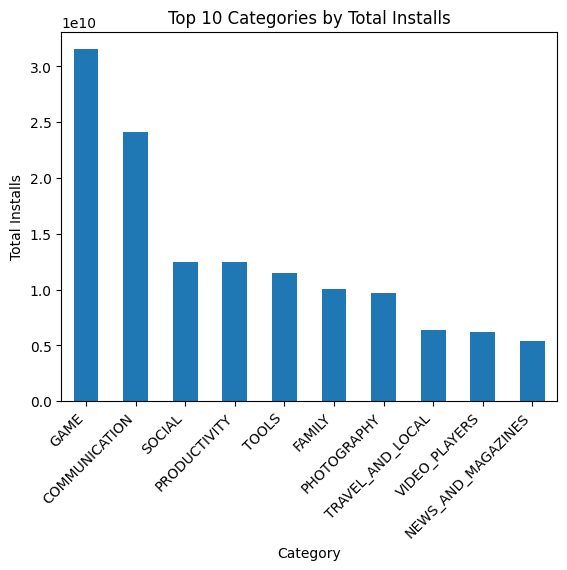

In [ ]:
top_cat = df.groupby("Category")["Installs"].sum().sort_values(ascending=False).head(10)
top_cat.plot(kind="bar")
plt.title("Top 10 Categories by Total Installs")
plt.xlabel("Category")
plt.ylabel("Total Installs")
plt.xticks(rotation=45, ha="right")
plt.show()


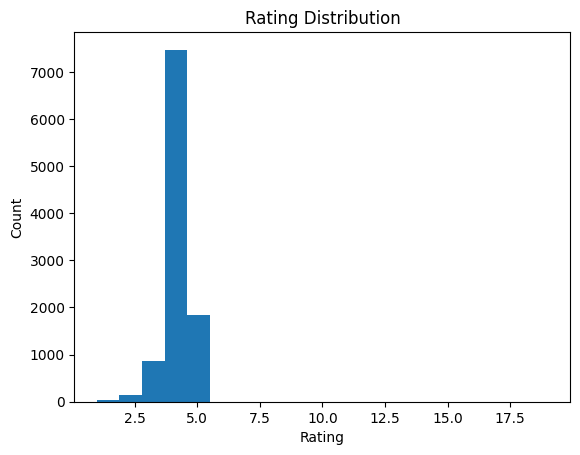

In [ ]:
plt.hist(df["Rating"], bins=20)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


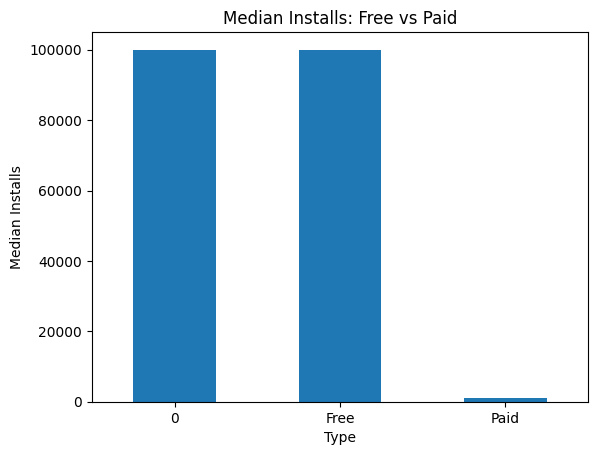

In [ ]:
inst_by_type = df.groupby("Type")["Installs"].median().sort_values(ascending=False)
inst_by_type.plot(kind="bar")
plt.title("Median Installs: Free vs Paid")
plt.xlabel("Type")
plt.ylabel("Median Installs")
plt.xticks(rotation=0)
plt.show()


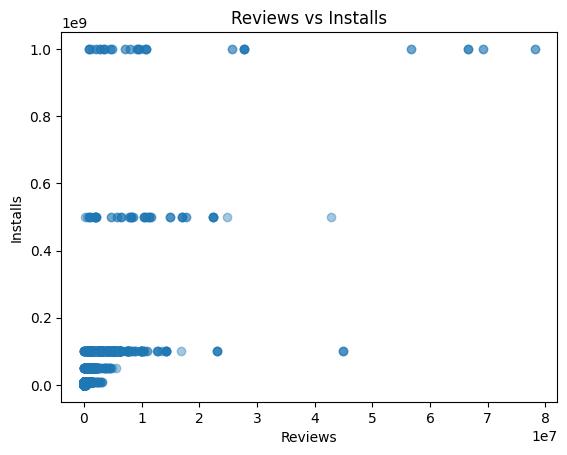

In [ ]:
plt.scatter(df["Reviews"], df["Installs"], alpha=0.4)
plt.title("Reviews vs Installs")
plt.xlabel("Reviews")
plt.ylabel("Installs")
plt.show()


In [ ]:
drop_cols = [c for c in ["Current Ver", "Android Ver"] if c in df.columns]
df = df.drop(columns=drop_cols)
print("Final shape:", df.shape)
df.head()


Final shape: (10358, 12)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Size_MB
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",19.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",14.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",8.7
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,50000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",25.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,100000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",2.8


In [ ]:
# Sanity check for large numeric values

print("Max Installs:", df["Installs"].max())
print("Min Installs:", df["Installs"].min())

print("Max Reviews:", df["Reviews"].max())
print("Max App Size (MB):", df["Size_MB"].max())
print("Max Price:", df["Price"].max())


Max Installs: 1000000000.0
Min Installs: 0.0
Max Reviews: 78158306.0
Max App Size (MB): 100.0
Max Price: 400.0
